In [114]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs

from pprint import pprint

In [3]:
DATA_PATH = '../data/'
EMBEDDING_DIR = '../embeddings/'

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

from subprocess import check_output
print(check_output(["ls", "../data"]).decode("utf8"))

abstracts.csv
arxiv_math_2007.csv
arxiv_math_2008.csv
arxiv_math_2009.csv
arxiv_math_2010.csv
arxiv_math_2011.csv
arxiv_math_2012.csv
arxiv_math_2013.csv
arxiv_math_2014.csv
arxiv_math_2015.csv
arxiv_math_2016.csv
arxiv_math_2017.csv
arxiv_math_2018.csv
arxiv_math.csv
ftabstract.csv
ftabstract_full.csv



In [4]:
#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('../embeddings/arxiv_vectors.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

43it [00:00, 389.31it/s]

loading word embeddings...


147680it [00:20, 7209.32it/s]

found 147680 word vectors


In [116]:
train_df = pd.read_csv('../data/arxiv_math.csv')
test_df = pd.read_csv('../data/arxiv_math_2008.csv')

In [117]:
raw_docs_train = (train_df['title'] + ' ' + train_df['abstract']).str.replace('\n', ' ').tolist()
raw_docs_test = (test_df['title'] + ' ' + test_df['abstract']).str.replace('\n', ' ').tolist()

In [118]:
import ast
def get_categories(categories):
    try:  
      return [x[5:] for x in ast.literal_eval(categories) if x[:5] == 'math.']
    except:
      return 'Missing'

In [119]:
train_df.categories = train_df.categories.apply(get_categories)
test_df.categories = test_df.categories.apply(get_categories)

In [120]:
categories = set()
for x in train_df.categories:
    categories = categories.union(set(x))

In [121]:
category_labels = list(categories)
num_classes = len(category_labels)

In [122]:
for x in tqdm(category_labels):
    train_df[x] = train_df.categories.apply(lambda li: x in li)
    test_df[x] = test_df.categories.apply(lambda li: x in li)

100%|██████████| 32/32 [00:04<00:00,  6.92it/s]


In [123]:
y_train = train_df[category_labels].values
y_test = test_df[category_labels].values

In [124]:
train_df['doc_len'] = (train_df['title'] + ' ' + train_df['abstract']).apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)

In [92]:
# print("pre-processing train data...")
# processed_docs_train = []
# for doc in tqdm(raw_docs_train):
#     tokens = tokenizer.tokenize(doc)
#     filtered = [word for word in tokens if word not in stop_words]
#     processed_docs_train.append(" ".join(filtered))

In [126]:
#training params
batch_size = 256 
num_epochs = 8 

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [127]:
print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=False, char_level=False)
tokenizer.fit_on_texts(raw_docs_train)  #leaky
word_seq_train = tokenizer.texts_to_sequences(raw_docs_train)
word_seq_test = tokenizer.texts_to_sequences(raw_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

tokenizing input data...
dictionary size:  217859


In [128]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words+1, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 49024


In [129]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['DyDW' "scale'" 'repre' 'Aug' 'cofficients' 'HLDBA' 'Puchta' 'MRAs'
 'AMRM' 'Leverrier']


In [130]:
#CNN architecture
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words+1, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='sigmoid'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

training CNN ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 157, 300)          30000300  
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 157, 64)           134464    
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 78, 64)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 78, 64)            28736     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 64)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080

In [131]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [132]:
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.1, shuffle=True)

Train on 345999 samples, validate on 38445 samples
Epoch 1/8
101888/345999 [=======>......................] - ETA: 12:47 - loss: 0.1844 - acc: 0.9430

KeyboardInterrupt: 

In [ ]:
abstract = ""

In [ ]:
model.predict(sequence.pad_sequences(tokenizer.texts_to_sequences(abstract), maxlen=max_seq_len))

In [103]:
y_pred = model.predict(word_seq_test)

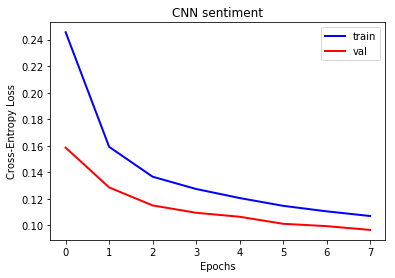

In [102]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')

In [104]:
y_pred

array([[4.3011241e-04, 8.9003406e-05, 1.9174408e-03, ..., 1.4488062e-02,
        8.2761303e-02, 8.1020861e-04],
       [1.0746837e-04, 1.8621227e-04, 1.1962975e-03, ..., 3.3815891e-01,
        5.7635436e-05, 1.2466063e-05],
       [2.9390643e-04, 1.5445848e-04, 7.2067004e-04, ..., 7.6756991e-02,
        2.8604938e-05, 3.1998272e-06],
       ...,
       [3.8193204e-03, 7.1905009e-02, 1.0932435e-03, ..., 5.4716426e-03,
        3.8472959e-04, 8.6481537e-04],
       [4.5133927e-03, 1.1754435e-03, 1.0495571e-03, ..., 1.6465356e-03,
        1.1361997e-04, 2.0231602e-03],
       [8.0859857e-03, 1.7172217e-02, 5.8006658e-04, ..., 5.6292615e-03,
        3.7220208e-04, 1.8574111e-04]], dtype=float32)

In [107]:
y_test[0]

array([False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [108]:
y_pred[0]

array([4.30112414e-04, 8.90034062e-05, 1.91744079e-03, 9.22247636e-06,
       1.64782081e-03, 3.99219291e-03, 5.09907529e-02, 2.12646592e-02,
       9.74711180e-01, 1.06365164e-03, 9.67186817e-04, 1.26108686e-02,
       5.46697434e-03, 1.59492549e-02, 1.54199358e-03, 4.20830818e-03,
       1.16032292e-03, 2.25585271e-02, 2.13255669e-04, 3.02162636e-02,
       3.16866650e-03, 4.35334491e-03, 7.03117767e-05, 1.61401462e-02,
       2.99659744e-03, 1.11353258e-02, 1.51528046e-03, 1.11350266e-04,
       9.28100708e-05, 1.44880619e-02, 8.27613026e-02, 8.10208614e-04],
      dtype=float32)

In [ ]:
model.predict('')